# CreditCardApproval MachineLearning Diana Max

## Setup notebook & fetch data

In [165]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import random

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, FunctionTransformer, TargetEncoder, label_binarize
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    precision_recall_curve,
    confusion_matrix,
    classification_report,
    make_scorer,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    DetCurveDisplay
)

from sklearn.model_selection import (
    cross_val_score,
    GridSearchCV, 
    KFold, 
    RandomizedSearchCV, 
    train_test_split, 
    StratifiedKFold, 
    cross_validate,
    RepeatedStratifiedKFold
)

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.base import clone
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier

In [166]:
credit_approval = fetch_ucirepo(id=27)

X = credit_approval.data.features
y = credit_approval.data.targets
df = credit_approval.data.original

In [167]:
y

,A16
0,+
1,+
2,+
3,+
4,+
...,...
685,-
686,-
687,-
688,-


## preprocessing

In [168]:
"""
Maybe add some more advanced techniques from here later: https://scikit-learn.org/stable/modules/preprocessing.html

"""

'\nMaybe add some more advanced techniques from here later: https://scikit-learn.org/stable/modules/preprocessing.html\n\n'

### feature engineering: mixed numerical categorical feature space (this is old code, use fully numerical feature space for now)

In [169]:
make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
        ),
        ['A1']
        
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='median'),
            MinMaxScaler()
        ),
        ['A2']
    ),
    (
        make_pipeline(
            FunctionTransformer(lambda col: col.mask(col != 'u', 'non-u')),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
           ),
        ['A4']
    ),
    (
        make_pipeline(
            FunctionTransformer(lambda col: col.replace({'v':'v', 'h':'h','bb':'other','ff':'other','j':'other','z':'other','dd':'other','n':'other','o':'other'})),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
        ),
        ['A7']
    ),
    (
        make_pipeline(
            FunctionTransformer(lambda col: col.replace({'g':'g', 's':'non-g','p':'non-g'})),
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(drop='first')
        ),
        ['A13']
    ),
    (
        'test',
        make_pipeline(
            FunctionTransformer(np.log1p),
            SimpleImputer(strategy='median'),
            MinMaxScaler()
        ),
        ['A11','A14','A15']
    ),
    # continuous default
    (
        make_pipeline(
            MinMaxScaler(),
        ),
        ['A3','A8']
    ),
    # categorical default
    (
        make_pipeline(
            OneHotEncoder(drop='first'),
        ),
        ['A9','A10', 'A12']
    ),
    
    # remove: A5, A6
    remainder='drop'
)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['A1']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['A2']),
                                ('pipeline-3',
                                 Pipeline(steps=[('functiontransformer...
                                ('test', 'test',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log1p'>)),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())])),
                                ('pipeline-6',
                                 Pipeline(steps=[('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['A3', 'A8']),
                                ('pipeline-7',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(drop='first'))]),
                                 ['A9', 'A10', 'A12'])])

### feature engineering: fully numerical feature space

#### variant 1: include A7

In [170]:
column_tweaker_include_a7 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse_output=False, drop='first')
        ),
        ['A1','A9','A10','A12']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['u']))
        ),
        ['A4']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A5']
    ),
    (
        make_pipeline(
            TargetEncoder(),
            SimpleImputer(strategy='median')
        ),
        ['A6', 'A7']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A13']
    ),
    (
        make_pipeline(
            FunctionTransformer(np.log1p),
            SimpleImputer(strategy='median')
        ),
        ['A2','A3','A8','A11','A14','A15']
    ),

    # leave everything else untouched
    remainder='drop'
)

#### variant 2: exclude A7

In [171]:
column_tweaker_exclude_a7 = make_column_transformer(
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            OneHotEncoder(sparse_output=False, drop='first')
        ),
        ['A1','A9','A10','A12']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['u']))
        ),
        ['A4']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A5']
    ),
    (
        make_pipeline(
            TargetEncoder(),
            SimpleImputer(strategy='median')
        ),
        ['A6']
    ),
    (
        make_pipeline(
            SimpleImputer(strategy='most_frequent'),
            FunctionTransformer(lambda col: label_binarize(col, classes=['g']))
        ),
        ['A13']
    ),
    (
        make_pipeline(
            FunctionTransformer(np.log1p),
            SimpleImputer(strategy='median')
        ),
        ['A2','A3','A8','A11','A14','A15']
    ),

    # leave everything else untouched
    remainder='drop'
)

### feature scaling

In [172]:
column_scaler = MinMaxScaler()

### PCA

In [173]:
column_pca = PCA(n_components=.99, svd_solver='full')

### put together pipelines

#### feature engineering pipeline 1

In [174]:
preprocessing_pipe = make_pipeline(
    column_tweaker_exclude_a7,
    column_scaler,
    column_pca
)
preprocessing_pipe

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['A1', 'A9', 'A10', 'A12']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('functiontr...
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(func=<function <lambda> at 0x000001D9D961D080>))]),
                                                  ['A13']),
                                                 ('pipeline-6',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  ['A2', 'A3', 'A8', 'A11',
                                                   'A14', 'A15'])])),
                ('minmaxscaler', MinMaxScaler()),
                ('pca', PCA(n_components=0.99, svd_solver='full'))])

#### feature engineering pipeline 2

In [175]:
"""

In which different formats do we need the data for different classifiers ?

"""

'\n\nIn which different formats do we need the data for different classifiers ?\n\n'

## train test validation split

In [176]:
# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)

In [177]:
y = y.values.ravel()
y[y=='+'] = 1
y[y=='-'] = 0
y = y.astype(np.int8)


In [178]:
X_preprocessed = preprocessing_pipe.fit_transform(X=X, y=y)

In [179]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(X_preprocessed, y, test_size=0.1, random_state=seed)
X_train.shape, y_train.shape

((621, 12), (621,))

In [180]:
X_test, X_validate, y_test, y_validate = train_test_split(X_test_validate, y_test_validate, test_size=.5)
(X_test.shape, y_test.shape), (X_validate.shape, y_validate.shape)

(((34, 12), (34,)), ((35, 12), (35,)))

In [181]:
X_train_test, y_train_test = np.concatenate((X_train, X_test)), np.concatenate((y_train, y_test))

In [182]:
np.concatenate((X_train))

array([ 0.26601904, -0.55324516, -0.41293061, ...,  0.4801647 ,
       -0.10331035, -0.0011813 ])

## train & optimise different models

On what to optimize ?

The task is o predict, if, given the different parameters, access to a credit card is denied or granted.

- The worst case would be to give access to a position that is obvious fraud (False Positive). Cost: The owner looses money.
- Rejecting access to a legit position (False Negative) would be inconvenient, since someone wouldn't be able to draw his money, but we consider it less of a problem than a False Positive.

- Obviously, a True Positive would be giving someone his money while a True Negative would be denying fraud.



In summary, we primarily optimize for the False Positive rate.

Additional metrics:
- The dataset is balanced therefore classificatino accuracy is a meaningfull metrix as well.

In [183]:
scoring = {"Accuracy": make_scorer(accuracy_score), "Precision": make_scorer(precision_score, pos_label = 1)}

How to compare classifiers ?
- Plot learning curves.
- Compare missclassified examples.
- Compare robustness in different CV-splits.

Next, we compare the performance of a variety of common ML classifiers. Since we are relativey naive to which classifiers could work, we try a diverse set.

#### Linear Discriminant Analysis

Parameters:
'priors' : The default value estimates the class proportions from the training set. Since our dataset with n<1000 is relatively small, class proportions might be slightly skewed leading to a suboptimal estimation from the training data .

In [184]:
lda = LinearDiscriminantAnalysis()

param_grid = {
    'priors':[[.05,.95], [.1,.9], [.15,.85],[.2,.8],
              [.25,.75], [.3,.7], [.35,.65], [.4,.6],
              [.45,.55], [.5,.5], [.55,.45], [.6,.4],
              [.65,.35], [.7,.3], [.75,.25], [.8,.2],
              [.85,.15], [.9,.1], [.95,.05]]
    }


lda_gscv = GridSearchCV(estimator=lda, param_grid=param_grid, cv=10, scoring=scoring, refit="Accuracy")
lda_gscv.fit(X_train_test, y_train_test)
lda_gscv.best_params_

{'priors': [0.8, 0.2]}

In [185]:
lda_gscv.cv_results_['mean_test_Accuracy'], lda_gscv.cv_results_['mean_test_Precision']

(array([0.78473193, 0.83515152, 0.84582751, 0.85188811, 0.85648019,
        0.85494172, 0.85648019, 0.85494172, 0.85494172, 0.85494172,
        0.85792541, 0.85337995, 0.85643357, 0.85491841, 0.8595338 ,
        0.86109557, 0.85193473, 0.84738928, 0.792331  ]),
 array([0.69126401, 0.75529111, 0.77248853, 0.78284752, 0.78964491,
        0.78905668, 0.79146309, 0.79071234, 0.79071234, 0.79071234,
        0.79967571, 0.80196759, 0.81455783, 0.81822272, 0.83566779,
        0.85209943, 0.85962841, 0.89279504, 0.9178841 ]))

In [186]:
y_pred = lda_gscv.best_estimator_.predict(X_validate)
y_validate.shape, accuracy_score(y_validate, y_pred), precision_score(y_validate, y_pred)

((35,), 0.8571428571428571, 0.8)

#### Quadratic Discriminant Analysis

In [187]:
qda = QuadraticDiscriminantAnalysis()

param_grid = {
    'priors':[[.05,.95], [.1,.9], [.15,.85],[.2,.8],
              [.25,.75], [.3,.7], [.35,.65], [.4,.6],
              [.45,.55], [.5,.5], [.55,.45], [.6,.4],
              [.65,.35], [.7,.3], [.75,.25], [.8,.2],
              [.85,.15], [.9,.1], [.95,.05]]
    }

qda_gscv = GridSearchCV(estimator=qda, param_grid=param_grid, cv=10, scoring=scoring, refit="Accuracy")
qda_gscv.fit(X_train_test, y_train_test)
qda_gscv.best_params_

{'priors': [0.75, 0.25]}

In [188]:
qda_gscv.cv_results_['mean_test_Accuracy'], qda_gscv.cv_results_['mean_test_Precision']

(array([0.85184149, 0.85643357, 0.85797203, 0.85645688, 0.85948718,
        0.86254079, 0.86251748, 0.86097902, 0.85944056, 0.86097902,
        0.86710956, 0.86251748, 0.86097902, 0.86249417, 0.86864802,
        0.86713287, 0.86405594, 0.86100233, 0.83659674]),
 array([0.79765589, 0.80478185, 0.8086152 , 0.80827037, 0.81319695,
        0.82108932, 0.82272924, 0.82406629, 0.82576111, 0.83235564,
        0.84367214, 0.84669708, 0.84583687, 0.85654119, 0.87251946,
        0.88504273, 0.89352822, 0.90543256, 0.92983841]))

In [189]:
y_pred = qda_gscv.best_estimator_.predict(X_validate)
y_validate.shape, accuracy_score(y_validate, y_pred), precision_score(y_validate, y_pred)

((35,), 0.8571428571428571, 0.8333333333333334)

#### Compare LDA and QDA

In [190]:
lda_gscv.best_estimator_.predict(X_validate) == qda_gscv.best_estimator_.predict(X_validate)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True])

### Random Forest

#### Baseline

In [191]:
clf = RandomForestClassifier(max_depth=6, random_state=seed)

clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [192]:
clf.score(X_validate, y_validate)

0.8571428571428571

#### GridSearchCV

In [193]:
# best values, so we don't need to run excessive GridSearch again
param_grid = {
    'n_estimators': [300],
    'max_depth': [None],
    'min_samples_split': [10],
    'min_samples_leaf': [4],
    'max_features': ['sqrt'],
    'bootstrap': [True],
    'criterion': ['entropy']
}

# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20, 30, 40, 50],
#     'min_samples_split': [2, 5, 10, 15, 20],
#     'min_samples_leaf': [1, 2, 4, 6, 8, 10],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False],
#     'criterion': ['gini', 'entropy']
# }

In [194]:
rf = RandomForestClassifier(random_state=seed)
cv = StratifiedKFold(n_splits=10)

search_rf = GridSearchCV(
    estimator=rf,
    scoring=scoring,
    param_grid=param_grid, 
    verbose=1,
    cv=cv,
    refit='Accuracy',
    n_jobs=-1)

search_rf.fit(X_train_test, y_train_test)
search_rf.cv_results_['mean_test_Accuracy']

Fitting 10 folds for each of 1 candidates, totalling 10 fits


array([0.86554779])

In [195]:
search_rf.best_params_ , search_rf.best_estimator_

({'bootstrap': True,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 4,
  'min_samples_split': 10,
  'n_estimators': 300},
 RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                        min_samples_split=10, n_estimators=300, random_state=42))

In [196]:
# Auswerten auf den validierungsdaten
print(f"Accuracy score RandomForestCalssifier: {accuracy_score(y_validate, search_rf.best_estimator_.predict(X_validate))}")

Accuracy score RandomForestCalssifier: 0.8571428571428571


### KNeighborsClassifier

#### Baseline

In [197]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_validate, y_validate)

0.8857142857142857

#### GridSearch

In [198]:
param_grid = [
    {
        'n_neighbors':[5, 10, 15], 
        'weights':['uniform', 'distance'], 
        'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'], 
        'p':[1, 2]
        }
        ]


In [199]:
neighbor = KNeighborsClassifier()
cv = StratifiedKFold(n_splits=5)

In [200]:
search_knn = GridSearchCV(
    estimator=neighbor,
    scoring=scoring,
    param_grid=param_grid, 
    verbose=1,
    cv=cv,
    refit='Accuracy',
    n_jobs=-1)

In [201]:
search_knn.fit(X_train_test, y_train_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'algorithm': ['auto', 'ball_tree', 'kd_tree',
                                        'brute'],
                          'n_neighbors': [5, 10, 15], 'p': [1, 2],
                          'weights': ['uniform', 'distance']}],
             refit='Accuracy',
             scoring={'Accuracy': make_scorer(accuracy_score),
                      'Precision': make_scorer(precision_score, pos_label=1)},
             verbose=1)

In [202]:
search_knn.cv_results_['mean_test_Accuracy'], search_knn.cv_results_['mean_test_Precision']

(array([0.84427481, 0.84885496, 0.85801527, 0.8519084 , 0.85038168,
        0.85648855, 0.85954198, 0.86412214, 0.86564885, 0.86870229,
        0.8610687 , 0.86564885, 0.84427481, 0.84885496, 0.85801527,
        0.8519084 , 0.85038168, 0.85648855, 0.85954198, 0.86412214,
        0.86564885, 0.86870229, 0.8610687 , 0.86564885, 0.84427481,
        0.84885496, 0.85801527, 0.8519084 , 0.85038168, 0.85648855,
        0.85954198, 0.86412214, 0.86564885, 0.86870229, 0.8610687 ,
        0.86564885, 0.84427481, 0.84885496, 0.85801527, 0.8519084 ,
        0.85038168, 0.85648855, 0.85954198, 0.86412214, 0.86564885,
        0.86870229, 0.8610687 , 0.86564885]),
 array([0.82746237, 0.8308228 , 0.84884656, 0.84109845, 0.85671957,
        0.84074074, 0.86081466, 0.85055003, 0.84674394, 0.8526791 ,
        0.84546906, 0.85171801, 0.82746237, 0.8308228 , 0.84884656,
        0.84109845, 0.85671957, 0.84074074, 0.86081466, 0.85055003,
        0.84674394, 0.8526791 , 0.84546906, 0.85171801, 0.82746237,
  

In [203]:
search_knn.best_params_ , search_knn.best_estimator_

({'algorithm': 'auto', 'n_neighbors': 15, 'p': 1, 'weights': 'distance'},
 KNeighborsClassifier(n_neighbors=15, p=1, weights='distance'))

In [204]:
# Auswerten auf den validierungsdaten
accuracy_score(y_validate, search_knn.best_estimator_.predict(X_validate))

0.8571428571428571

### 

### Adaboost
A ensemble method

#### Baseline

In [205]:
# ada = AdaBoostClassifier(LinearDiscriminantAnalysis())
# ada_cv_result = cross_val_score(ada, X_preprocessed, y.values.ravel(), cv=10)

#### GridSearchCV

In [206]:
"""
Check if all these methods always categorize the same, or different samples wrong. If the later is the case, this would motivate using a ensemble method to balance strengths and weaknesses of different classifiers.

Maybe building some ensemble method that combines a (gradient boosted) dewcicion tree for the categorical variables with something like SVM for the continuous data.

This would obviate the need for target encoding of A6 and A7 and poosible better handle the many binary variables in the dataset. 
""";

## (Sequential Feature Selection)

In [207]:
"""
Further reduce dimensionality by SFS. This may give different results for different classifiers.

Compare results of SFS to results of EDA
"""

'\nFurther reduce dimensionality by SFS. This may give different results for different classifiers.\n\nCompare results of SFS to results of EDA\n'

## model comparison

In [208]:

print('Best RandomForestClassifier Accuracy:', accuracy_score(y_validate, search_rf.best_estimator_.predict(X_validate)))
print('Best KNeighborsClassifier Accuracy:', accuracy_score(y_validate, search_knn.best_estimator_.predict(X_validate)))

Best RandomForestClassifier Accuracy: 0.8571428571428571
Best KNeighborsClassifier Accuracy: 0.8571428571428571


Text(0.5, 1.0, 'Precision-Recall curve')

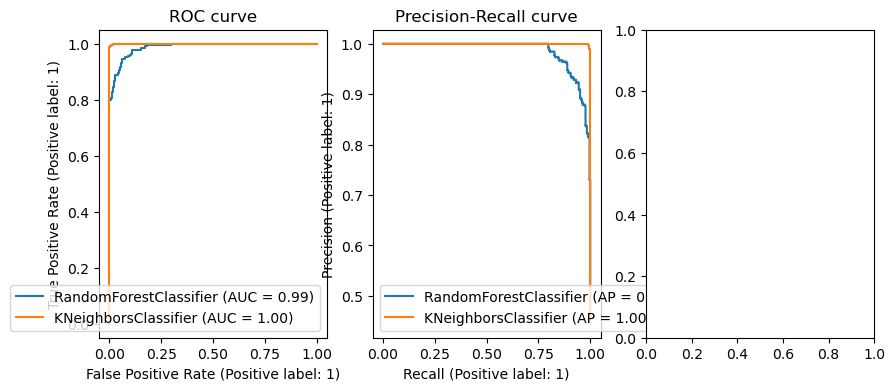

In [209]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

RocCurveDisplay.from_estimator(search_rf.best_estimator_, X_preprocessed, y, ax=ax1)
RocCurveDisplay.from_estimator(search_knn.best_estimator_, X_preprocessed, y, ax=ax1)
ax1.set_title("ROC curve")

PrecisionRecallDisplay.from_estimator(search_rf.best_estimator_, X_preprocessed, y, ax=ax2)
PrecisionRecallDisplay.from_estimator(search_knn.best_estimator_, X_preprocessed, y, ax=ax2)
ax2.set_title("Precision-Recall curve")

#DetCurveDisplay.from_estimator(search_rf.best_estimator_, X_preprocessed, y, ax=ax3)



In [210]:
y_num = np.where(y_train == '+', 1, 0)
y_validate_num = np.where(y_validate == '+', 1, 0)

rf_num = search_rf.best_estimator_.fit(X_train, y_num)
knn_num = search_knn.best_estimator_.fit(X_train, y_num)




In [211]:
#DetCurveDisplay.from_predictions(y_validate, rf_best.predict)
# Get prediction probabilities
rf_best = search_rf.best_estimator_
# probabilities = rf_best.predict_proba(X_validate)
# print("Prediction Probabilities:\n", probabilities)

In [212]:

# Get class predictions (optional)
predictions_rf = rf_num.predict(X_validate)
print("Class Predictions:\n", predictions_rf)

predictions_knn = knn_num.predict(X_validate)
print("Class Predictions:\n", predictions_knn)

# DetCurveDisplay.from_predictions(y_validate_num, predictions_rf)
# DetCurveDisplay.from_predictions(y_validate_num, predictions_knn)

Class Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Class Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [213]:
# Model evauation

# Since classes are balanced, accuracy is the correct evaluation metric.

# Plot ROC for different hyperparameters

# above: plot full results of grid search to showcase effects of different hyperparameters